### - LSTM based approach from Keras

In [1]:
import csv
import pandas as pd
import json
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import InputLayer, TimeDistributed, SpatialDropout1D, Bidirectional
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import plotly.express as px
from sklearn.model_selection import train_test_split
import tqdm
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback
import datetime
import os

In [2]:
with open('../annotatedData/annotations.json', 'r') as f:
    data = json.load(f)

### - Preprocessing the annotated Data into csv format for train the model

In [3]:
def extract_entities(sentence, entities):
    entity_list = []
    words = [buchstabe for buchstabe in sentence]
    for entity in entities:
        start = entity[0]
        end = entity[1]
        entity_type = entity[2]
        word = ''.join(words[start:end])
        entity_list.append((start, word, entity_type))
    return entity_list

with open('output.csv', mode='w', newline='', encoding='utf-8') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(['Index', 'Word', 'EntityType'])
    
    for index, item in enumerate(data['annotations'], start=1):
        sentence = item[0][:]
        entities = item[1]['entities']
        entity_list = extract_entities(sentence, entities)

        current_index = 0
        for entry in entity_list:
            start, word, entity_type = entry
            while current_index < start:
                char = sentence[current_index]
                writer.writerow([index, char, 'o'])
                current_index += 1

            writer.writerow([index, word, entity_type])
            current_index += len(word)

        while current_index < len(sentence):
            char = sentence[current_index]
            writer.writerow([index, char, 'o'])
            current_index += 1

In [4]:
def process_csv_file(input_file, output_file):
    with open(input_file, mode='r', newline='', encoding='utf-8') as csv_file:
        reader = csv.reader(csv_file)
        data = list(reader)

    modified_data = []
    current_row = 0

    while current_row < len(data):
        index, word, entity_type = data[current_row]

        if len(word) == 1 and word.strip() == "":
            # Remove the entire row if the word contains only a single space
            current_row += 1
        else:
            if len(word) == 1 and not word.strip() == "":
                # If the word contains a single non-empty character,
                # concatenate it with the following rows until an empty word is encountered
                merged_word = word
                next_row = current_row + 1

                while next_row < len(data):
                    next_word = data[next_row][1]
                    if next_word.strip() == "":
                        break

                    merged_word += next_word
                    next_row += 1

                modified_data.append([index, merged_word, entity_type])
                current_row = next_row
            else:
                modified_data.append([index, word, entity_type])
                current_row += 1

    with open(output_file, mode='w', newline='', encoding='utf-8') as csv_file:
        writer = csv.writer(csv_file)
        writer.writerows(modified_data)

input_file = 'output.csv'
output_file = 'output_modified1.csv'
process_csv_file(input_file, output_file)

In [5]:
def process_csv_file(input_file, output_file):
    with open(input_file, mode='r', newline='', encoding='utf-8') as csv_file:
        reader = csv.reader(csv_file)
        data = list(reader)

    modified_data = []
    for index, word, entity_type in data:
        if word.endswith('.'):
            modified_data.append([index, word[:-1], entity_type])
            modified_data.append([index, '.', 'o'])
        else:
            modified_data.append([index, word, entity_type])

    with open(output_file, mode='w', newline='', encoding='utf-8') as csv_file:
        writer = csv.writer(csv_file)
        writer.writerows(modified_data)

input_file = 'output_modified1.csv'
output_file = 'output_modified2.csv'
process_csv_file(input_file, output_file)

### Main Part

In [6]:
np.random.seed(0)
plt.style.use("ggplot")

In [7]:
data = pd.read_csv("output_modified2.csv", encoding="UTF-8")

data = data.fillna(method="ffill")
data.head(20)

,Index,Word,EntityType
0,1,Text:,o
1,1,Ein,KARDINALITÄT
2,1,Geschäft,ENTITÄT
3,1,hat,BEZIEHUNG
4,1,viele,KARDINALITÄT
5,1,Filialen,ENTITÄT
6,1,.,o
7,1,Jede,KARDINALITÄT
8,1,Filiale,ENTITÄT
9,1,darf,o


In [8]:
print("Unique words in corpus:", data['Word'].nunique())
print("Unique tags in corpus:", data['EntityType'].nunique())

Unique words in corpus: 87
Unique tags in corpus: 8


In [9]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
num_words = len(words)

tags = list(set(data["EntityType"].values))
num_tags = len(tags)

In [10]:
fig = px.histogram(data[~data.EntityType.str.contains("o")], x="EntityType",color="EntityType")
fig.show()

### Data Manipulation 

In [11]:
def sentence_integrate(data):
  agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),s["EntityType"].values.tolist())]
  return data.groupby('Index').apply(agg_func).tolist()

In [12]:
sentences=sentence_integrate(data)

In [13]:
fig = px.histogram(pd.DataFrame([len(s) for s in sentences],columns=['length']),x="length",marginal='box')
fig.show()

In [14]:
sentences[0]

[('Text:', 'o'),
 ('Ein', 'KARDINALITÄT'),
 ('Geschäft', 'ENTITÄT'),
 ('hat', 'BEZIEHUNG'),
 ('viele', 'KARDINALITÄT'),
 ('Filialen', 'ENTITÄT'),
 ('.', 'o'),
 ('Jede', 'KARDINALITÄT'),
 ('Filiale', 'ENTITÄT'),
 ('darf', 'o'),
 ('von', 'o'),
 ('höchstens einem', 'KARDINALITÄT'),
 ('Filialleiter', 'ENTITÄT')]

### Build a vocabulary for words and tags

In [15]:
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [16]:
tag2idx

{'ISA': 0,
 'BEZIEHUNG': 1,
 'ENTITÄT': 2,
 'MEHRWERTIGES ATTRIBUT': 3,
 'PRIMÄRSCHLÜSSEL': 4,
 'o': 5,
 'KARDINALITÄT': 6,
 'ATTRIBUT': 7}

### Padding the input sentence to the same length (50)

In [17]:
max_len = 50

X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=num_words-1)

y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["o"])

In [18]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

### Build and Compile a Bidirectional LSTM Model

In [19]:
model = keras.Sequential()
model.add(InputLayer((max_len)))
model.add(Embedding(input_dim=num_words, output_dim=max_len, input_length=max_len))
model.add(SpatialDropout1D(0.1))
model.add(Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1)))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 50)            4400      
                                                                 
 spatial_dropout1d (Spatial  (None, 50, 50)            0         
 Dropout1D)                                                      
                                                                 
 bidirectional (Bidirection  (None, 50, 200)           120800    
 al)                                                             
                                                                 
Total params: 125200 (489.06 KB)
Trainable params: 125200 (489.06 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


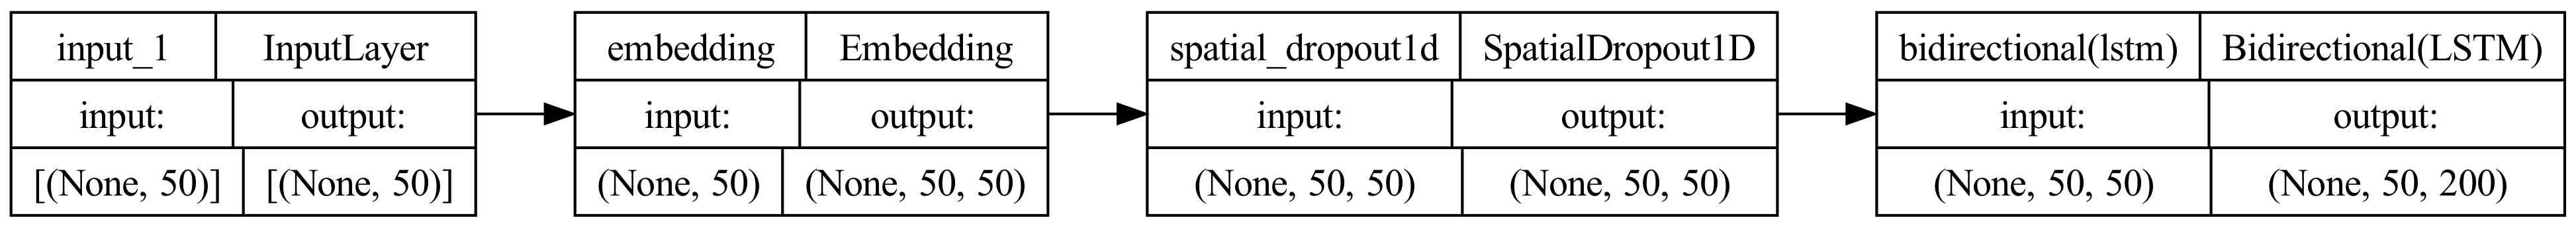

In [20]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True, show_dtype=False,
    show_layer_names=True, rankdir='LR', expand_nested=True, dpi=300,
)

In [21]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

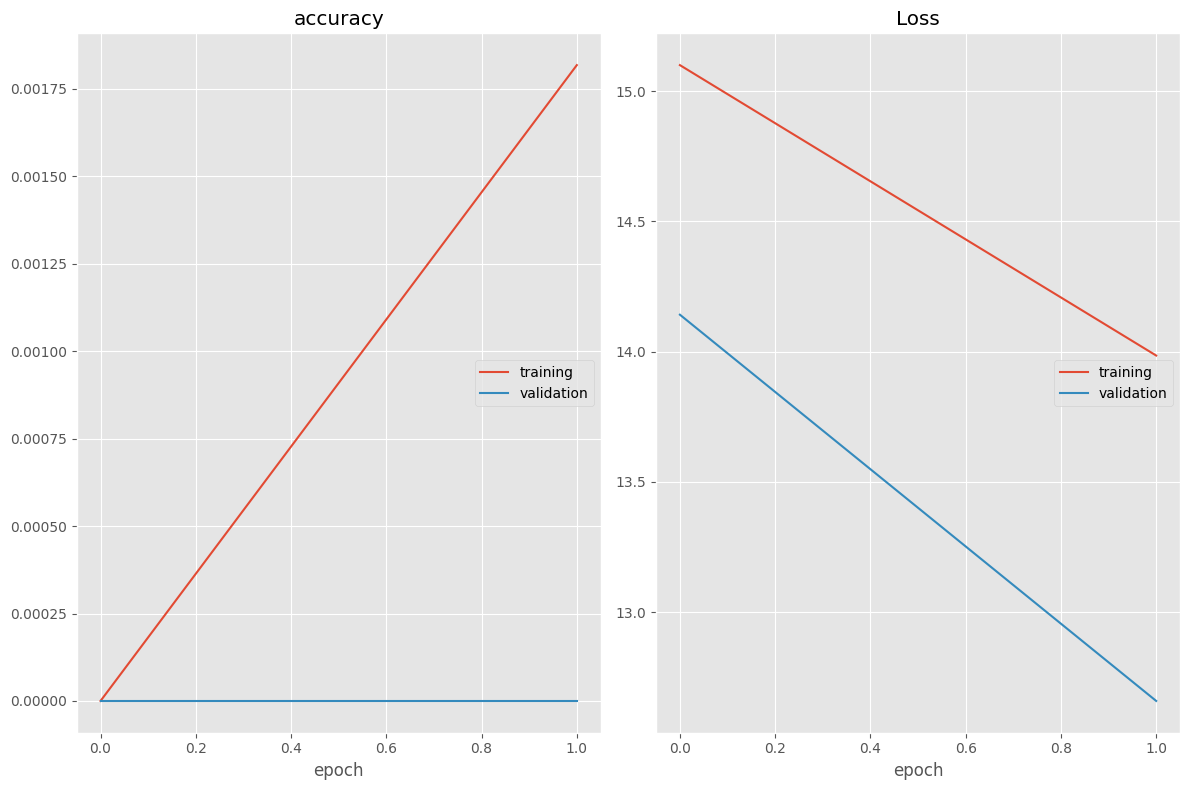

accuracy
	training         	 (min:    0.000, max:    0.002, cur:    0.002)
	validation       	 (min:    0.000, max:    0.000, cur:    0.000)
Loss
	training         	 (min:   13.985, max:   15.099, cur:   13.985)
	validation       	 (min:   12.659, max:   14.142, cur:   12.659)

Epoch 2: val_loss improved from 14.14151 to 12.65898, saving model to model_weights.h5
1/1 [==============================] - 0s 238ms/step - loss: 13.9847 - accuracy: 0.0018 - val_loss: 12.6590 - val_accuracy: 0.0000e+00


In [22]:
#%%time

logdir="./logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

chkpt = ModelCheckpoint("model_weights.h5", monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=True, mode='min')

early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=1, verbose=0, mode='max', baseline=None, restore_best_weights=False)

callbacks = [PlotLossesCallback(), chkpt, early_stopping,tensorboard_callback]


history = model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_test,y_test),
    batch_size=32, 
    epochs=3,
    callbacks=callbacks,
    verbose=1
    
)

In [26]:

#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [23]:
dirs = os.listdir()
if 'models' not in dirs:
    os.makedirs('models')
    
model.save(f'models/test-128-10.tf', save_format='tf')

INFO:tensorflow:Assets written to: models/test-128-10.tf/assets


INFO:tensorflow:Assets written to: models/test-128-10.tf/assets


In [28]:
# %load_ext tensorboard

# %tensorboard --logdir logs

In [24]:
print("Evaluate on test data")
results = model.evaluate(x_test, y_test, batch_size=128)
print("test loss: {} ".format(results[0]))
print("test accuracy: {} ".format(results[1]))

Evaluate on test data
1/1 [==============================] - 0s 21ms/step - loss: 12.6590 - accuracy: 0.0000e+00
test loss: 12.658982276916504 
test accuracy: 0.0 


In [26]:
# reclassification

i = np.random.randint(0, x_train.shape[0])
print(x_train.shape[0])
print("This is sentence:",i)
p = model.predict(np.array([x_train[i]]))
p = np.argmax(p, axis=-1)

print("{:15}{:30}\t {}\n".format("Word", "True", "Pred"))
print("-" *30)
for w, true, pred in zip(x_train[i], y_train[i], p[0]):
    print(y_train[i])
    print(p[0])
    #print(words[w-1])
    #print(tags[true])
    #print(tags[pred])
    print("{:15}\t{}".format(words[w-1], tags[true]), tags[pred])

11
This is sentence: 0
1/1 [==============================] - 0s 15ms/step
Word           True                          	 Pred

------------------------------
[5 2 5 5 2 5 5 5 2 1 6 2 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5]
[134 133  27 198 133  87  87  87  27  27  27 192 192 192 192 192 192 192
 192 192 192 192 192 192 192 192 192 192 192 192 192 192 192 192 192 192
 192 192 192 192 192 192  14  14  14  14  14  14  14  14]


IndexError: list index out of range

In [ ]:
# solution for the error: must train with more data 
# überprüfen wie man labelt wenn keine class zugeodnet wird

In [27]:
# test with test data (no reclassification)

i = np.random.randint(0, x_test.shape[0])
print("This is sentence:",i)
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)

print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
print("-" *30)
for w, true, pred in zip(x_test[i], y_test[i], p[0]):
    print("{:15}{}\t{}".format(words[w-1], tags[true], tags[pred]))

This is sentence: 1
1/1 [==============================] - 0s 14ms/step
Word           True 	 Pred

------------------------------


IndexError: list index out of range

In [ ]:
# confusion matrix als vergleich mit spacy model